# Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы: 

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
 
- customer_id — позаказный идентификатор пользователя

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5



Уникальные статусы заказов в таблице olist_orders_dataset:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
sns.set(
    font_scale = 2, 
    style      ='whitegrid', 
    rc         ={'figure.figsize':(20,7)})

In [3]:
os.listdir()

['olist_customers_dataset.csv',
 '.ipynb_checkpoints',
 'prom_project.ipynb',
 'olist_order_items_dataset.csv',
 'olist_orders_dataset.csv']

In [3]:
path_1 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-u-yusupov-35/prom_project/olist_customers_dataset.csv'

In [4]:
path_2 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-u-yusupov-35/prom_project/olist_order_items_dataset.csv'

In [5]:
path_3 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-u-yusupov-35/prom_project/olist_orders_dataset.csv'

In [7]:
df_customer_id = pd.read_csv(path_1)
df_customer_id.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [8]:
df_items_id = pd.read_csv(path_2, parse_dates=['shipping_limit_date'])
df_items_id.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [9]:
df_orders_id = pd.read_csv(path_3, parse_dates=['order_purchase_timestamp', 
                                               'order_approved_at', 'order_delivered_carrier_date', 
                                                'order_delivered_customer_date', 'order_estimated_delivery_date'])
df_orders_id.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


# Задание_1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [10]:
df_1 = pd.merge(pd.merge(df_customer_id,df_orders_id,how='left', on='customer_id'),df_items_id,how='left',on='order_id')
df_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [11]:
# посмотрим количество покупателей 

df_1.customer_id.value_counts()

fc3d1daec319d62d49bfb5e1f83123e9    21
be1b70680b9f9694d8c70f41fa3dc92b    20
bd5d39761aa56689a265d95d8d32b8be    20
adb32467ecc74b53576d9d13a5a55891    15
10de381f8a8d23fff822753305f71cae    15
                                    ..
6366405f9937312b89b389f96d2f82f8     1
10926161cddd1f0ad0e0c705109a334c     1
7104377ff862cd25542730eed8873d67     1
1421cb63f0a9dedc0c36b0b96bb60ec5     1
a3ba7119f6a86d7db5e045d44ce6b25f     1
Name: customer_id, Length: 99441, dtype: int64

In [12]:
# проверим одного пользователя, какие заказы он делал

df_1[df_1.customer_id == 'fc3d1daec319d62d49bfb5e1f83123e9'] # вижу что имеются или ошибки или дубликаты по заказам 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
53735,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53736,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53737,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53738,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53739,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53740,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,6.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53741,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,7.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53742,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,8.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53743,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,9.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
53744,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,10.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [11]:
len_df = df_1.drop_duplicates(subset='order_id')
len_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
113421,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
113422,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
113423,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,1.0,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [14]:
len_df[len_df.customer_id == 'fc3d1daec319d62d49bfb5e1f83123e9'] # вижу что удалились дубликаты 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
53735,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [14]:
pd.set_option('display.max_rows', 100) # это для того чтобы смотреть количество строк 

In [15]:
len_df.query('order_status == "delivered"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1').order_id.sum() 

# количество пользователей которые сделали закуп один раз

90557

# Задание_2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [21]:
canceled_df = len_df.query('order_status in ("canceled", "unavailable")') \
    .groupby(['order_status'], as_index=False) \
    .agg({'order_id': 'count'}) # количество пользователей отменивших заказыы

In [16]:
canceled_df

,order_status,order_id
0,canceled,625
1,unavailable,609


In [19]:
len_df['month'] = len_df.order_estimated_delivery_date.apply(lambda x: x.strftime('%Y-%m'))
len_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [28]:
mean_task_4 = len_df.query('order_status in ("canceled", "unavailable")') \
    .groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'})

In [31]:
# среднее количество заказов которые не доставляются 
canceled_mean = mean_task_4.groupby('order_status', as_index=False).agg({'order_id': 'mean'})
canceled_mean 

,order_status,order_id
0,canceled,24.038462
1,unavailable,29.000000


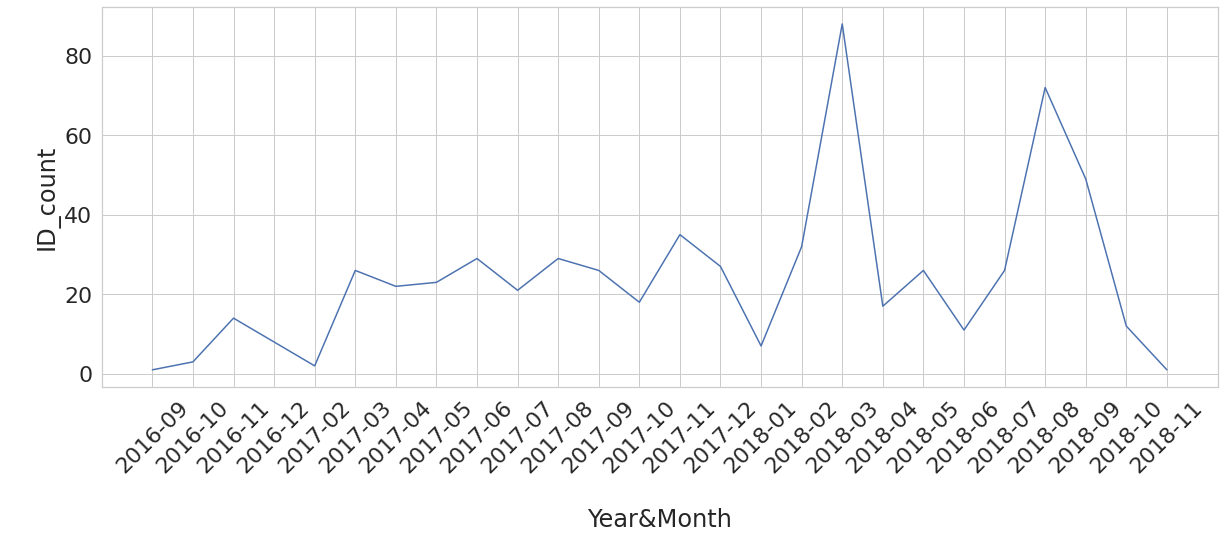

In [34]:
# визуализируем отмененные заказы и посмотрим в разрезе даты 
canceled_mean = len_df.query('order_status == "canceled"') \
    .groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'})

ax = sns.lineplot(data=canceled_mean, x="month", y="order_id")
ax.set(xlabel='\nYear&Month', ylabel='\nID_count')
ax.tick_params(axis='x', rotation=45)

# Задание_3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [13]:
len_df['day'] = len_df['order_purchase_timestamp'].dt.day_name()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
# выведим количество заказов по наименованию дней 
len_df.day.value_counts()

Monday       16196
Tuesday      15963
Wednesday    15552
Thursday     14761
Friday       14122
Sunday       11960
Saturday     10887
Name: day, dtype: int64

In [23]:
popular_days = len_df.groupby(['product_id', 'day'], as_index=False) \
    .agg({'price': 'count'})
popular_days

,product_id,day,price
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
59117,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59118,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
59119,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
59120,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [24]:
popular_days = popular_days.pivot(index='product_id', columns='day', values='price') \
            .idxmax(axis=1).to_frame()

In [25]:
# самый популярный день понедельник 
popular_days = popular_days.reset_index().rename(columns={0:'popular_days'})

In [26]:
popular_days.query('product_id == "99a4788cb24856965c36a24e339b6058"')

,product_id,popular_days
19099,99a4788cb24856965c36a24e339b6058,Monday


# Задание_4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

колонки которые нужны для решения задачи 

- customer_id - пользователи 
- order_purchase_timestamp - время заказа (покупка)
- order_id - заказы 
- customer_unique_id - уникальные пользователи 

In [ ]:
# Доработка после замечания 17.03.2023
# используем таблицы:
#      - df_orders_id
#      - df_customer_id

In [102]:
df_orders_id.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [134]:
task_4 = df_orders_id.merge(df_customer_id, how='left', on='customer_id')

In [135]:
task_4 = task_4[['customer_id', 'order_purchase_timestamp', 'order_id', 'customer_unique_id', 'order_status']]

In [136]:
task_4['order_purchase_timestamp'] = pd.to_datetime(task_4['order_purchase_timestamp'])

In [137]:
task_4.dtypes

customer_id                         object
order_purchase_timestamp    datetime64[ns]
order_id                            object
customer_unique_id                  object
order_status                        object
dtype: object

In [138]:
task_4 = task_4[task_4['order_status'].isin(['delivered'])]

In [139]:
task_4.order_status.value_counts()

delivered    96478
Name: order_status, dtype: int64

In [140]:
month_count = task_4.groupby(['order_purchase_timestamp', 'customer_unique_id'], as_index=False).agg({'order_id': 'count'})

In [141]:
month_count.head()

,order_purchase_timestamp,customer_unique_id,order_id
0,2016-09-01,830d5b7aaa3b6f1e9ad63703bec97d23,1
1,2016-10-01,0032c76b20340da25249092a268ce66c,1
2,2016-10-01,01f156677184504063bd19739f924af1,1
3,2016-10-01,0636d30c77f0f9cfad81f1c9b58c791f,1
4,2016-10-01,06bdfbbe1857c3c925ec81abfb1c9666,1


In [142]:
month_count['weekdays'] = (month_count.order_purchase_timestamp.dt.daysinmonth) / 7

In [143]:
month_count['order_purchase_timestamp'] = month_count.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))

In [144]:
month_count.order_purchase_timestamp.value_counts()

2017-11    7183
2018-01    6974
2018-03    6914
2018-04    6744
2018-05    6693
2018-02    6400
2018-08    6310
2018-07    6100
2018-06    6061
2017-12    5450
2017-10    4417
2017-08    4114
2017-09    4083
2017-07    3802
2017-05    3479
2017-06    3076
2017-03    2508
2017-04    2274
2017-02    1630
2017-01     718
2016-10     262
2016-12       1
2016-09       1
Name: order_purchase_timestamp, dtype: int64

In [145]:
month_count.order_id.value_counts()

1    93971
2     1172
3       43
4        7
6        1
Name: order_id, dtype: int64

In [146]:
month_count.head()

,order_purchase_timestamp,customer_unique_id,order_id,weekdays
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714
1,2016-10,0032c76b20340da25249092a268ce66c,1,4.428571
2,2016-10,01f156677184504063bd19739f924af1,1,4.428571
3,2016-10,0636d30c77f0f9cfad81f1c9b58c791f,1,4.428571
4,2016-10,06bdfbbe1857c3c925ec81abfb1c9666,1,4.428571


In [147]:
1 / 4.285714

0.23333334888888996

In [148]:
# получим результат ср.покупка в неделю по каждому пользователю 
month_count['avg_rate'] = month_count.order_id / month_count.weekdays.round(0)

In [149]:
month_count.head(3)

,order_purchase_timestamp,customer_unique_id,order_id,weekdays,avg_rate
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714,0.25
1,2016-10,0032c76b20340da25249092a268ce66c,1,4.428571,0.25
2,2016-10,01f156677184504063bd19739f924af1,1,4.428571,0.25


 # Задание_5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

In [14]:
task_5 = len_df[['customer_unique_id', 'order_purchase_timestamp']]

In [15]:
task_5['start_date'] = len_df.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
task_5.set_index('customer_unique_id', inplace=True)

In [17]:
task_5['start_date_min'] = task_5.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
task_5.loc['7c396fd4830fd04220f754e42b4e5bff']

,order_purchase_timestamp,start_date,start_date_min
customer_unique_id,,,
7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:26:38,2017-09,2017-09


In [19]:
task_5.reset_index(inplace=True)

In [20]:
task_5_analysis = task_5.groupby(['start_date_min', 'start_date']) \
                   .agg({'customer_unique_id': 'nunique'})

In [21]:
task_5_analysis  

customer_unique_id
start_date_min start_date                    
2016-09        2016-09                      4
2016-10        2016-10                    321
               2017-04                      1
               2017-07                      1
               2017-09                      1
...                                       ...
2018-08        2018-08                   6271
               2018-09                      7
               2018-10                      2
2018-09        2018-09                      5
2018-10        2018-10                      1

[225 rows x 1 columns]

In [22]:
def CohortPeriod(x):
    x['kogort'] = np.arange(len(x)) + 0
    return x
task_5_analysis = task_5_analysis.groupby(level=0).apply(CohortPeriod)

In [23]:
task_5_analysis

customer_unique_id  kogort
start_date_min start_date                            
2016-09        2016-09                      4       0
2016-10        2016-10                    321       0
               2017-04                      1       1
               2017-07                      1       2
               2017-09                      1       3
...                                       ...     ...
2018-08        2018-08                   6271       0
               2018-09                      7       1
               2018-10                      2       2
2018-09        2018-09                      5       0
2018-10        2018-10                      1       0

[225 rows x 2 columns]

In [24]:
task_5_analysis_kogort = task_5_analysis

In [25]:
task_5_analysis_kogort.reset_index(inplace=True)
task_5_analysis_kogort.set_index(['kogort', 'start_date_min'], inplace=True)


In [26]:
task_5_analysis_kogort.head()

start_date  customer_unique_id
kogort start_date_min                               
0      2016-09           2016-09                   4
       2016-10           2016-10                 321
1      2016-10           2017-04                   1
2      2016-10           2017-07                   1
3      2016-10           2017-09                   1

In [27]:
task_5_analysis_kogort['customer_unique_id'].unstack(0)

kogort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
start_date_min,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN


In [28]:
task_5_analysis_kogort_2 = task_5_analysis_kogort['customer_unique_id'].groupby(level=1).first()

In [29]:
retention = task_5_analysis_kogort['customer_unique_id'].unstack(0).divide(task_5_analysis_kogort_2, axis=0)

In [30]:
retention_percent = (retention.round(3) * 100)

In [31]:
retention_percent

kogort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
start_date_min,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,0.3,0.3,0.3,0.3,0.3,0.3,0.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.4,0.3,0.1,0.4,0.1,0.5,0.1,0.1,0.4,0.1,0.8,0.4,0.1,0.1,0.3,0.4,0.1
2017-02,100.0,0.2,0.3,0.1,0.4,0.1,0.2,0.2,0.2,0.2,0.1,0.3,0.2,0.2,0.1,0.1,0.1,0.2
2017-03,100.0,0.5,0.4,0.4,0.3,0.2,0.2,0.3,0.3,0.1,0.4,0.2,0.2,0.1,0.2,0.2,0.1,0.2
2017-04,100.0,0.6,0.2,0.2,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.1,0.1,0.0,0.1,0.1,0.2,NaN
2017-05,100.0,0.5,0.5,0.4,0.3,0.3,0.4,0.2,0.3,0.3,0.3,0.3,0.3,0.0,0.2,0.3,NaN,NaN
2017-06,100.0,0.5,0.4,0.4,0.3,0.4,0.4,0.2,0.1,0.2,0.3,0.4,0.2,0.1,0.2,NaN,NaN,NaN


In [33]:
# возьму стиль из 8 урока
ur_style = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

# ответ: 
#     высокий показатель когорты на 3-й месяц выявлена у периода 2017-06 (июнь) в размере 0.41%

kogort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
start_date_min,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,
2016-10,100.00%,0.31%,0.31%,0.31%,0.31%,0.31%,0.31%,0.62%,0.62%,,,,,,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,


In [47]:
def get_cohort_matrix(task_5, customer_unique_id, order_purchase_timestamp):  #делаем функцию
    task_5['start_date'] = len_df.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
    task_5.set_index('customer_unique_id', inplace=True)
    task_5['start_date_min'] = task_5.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
    task_5.reset_index(inplace=True)

    task_5_analysis = task_5.groupby(['start_date_min', 'start_date']) \
                   .agg({'customer_unique_id': 'nunique'})

    def CohortPeriod(x):
        x['kogort'] = np.arange(len(x)) + 0
        return x
    task_5_analysis = task_5_analysis.groupby(level=0).apply(CohortPeriod)
    
    task_5_analysis.reset_index(inplace=True)
    task_5_analysis.set_index(['kogort', 'start_date_min'], inplace=True)
    task_5_analysis_kogort = task_5_analysis['customer_unique_id'].groupby(level=1).first()
    retention = task_5_analysis['customer_unique_id'].unstack(0).divide(task_5_analysis_kogort, axis=0)
    
    return retention

In [48]:
(retention.style
            .set_caption('User retention by cohort')
            .background_gradient(cmap='viridis')  
            .highlight_null('white')  
            .format("{:.2%}", na_rep="")) 

kogort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
start_date_min,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,
2016-10,100.00%,0.31%,0.31%,0.31%,0.31%,0.31%,0.31%,0.62%,0.62%,,,,,,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,


# Задание_6. 

In [12]:
task_6 = len_df[['customer_unique_id', 'order_purchase_timestamp', 'order_status', 'price']]

In [13]:
task_6.shape

(99441, 4)

In [14]:
# calculate Recency = number of days since last purchase (последняя дата покупки) 

last_day = max(task_6.order_purchase_timestamp) + timedelta(days=1)

In [15]:
type(last_day)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
calc_recency = task_6.groupby('customer_unique_id', as_index=False) \
                     .agg({'order_purchase_timestamp': lambda x: (last_day - x.max()).days}) \
                        .rename(columns={'order_purchase_timestamp': 'calc_recency'})

In [17]:
calc_recency.head(3)

,customer_unique_id,calc_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,161
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164
2,0000f46a3911fa3c0805444483337064,586


In [18]:
# calculate Freqency = number of purchases during the studied period (usually one year) количество заказов 
calc_freqency = task_6.groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'count'}).rename(columns={'order_purchase_timestamp': 'calc_freqency'})

In [19]:
calc_freqency.head(3)

,customer_unique_id,calc_freqency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1


In [20]:
# calculate Monetary = total amount of purchases made during the studied period (сумма покупок)
calc_monetary = task_6.groupby('customer_unique_id', as_index=False).price.sum().rename(columns={'price': 'calc_monetary'})

In [21]:
calc_monetary.head(3)

,customer_unique_id,calc_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.9
2,0000f46a3911fa3c0805444483337064,69.0


In [22]:
calc_monetary['calc_monetary'] = calc_monetary.calc_monetary.apply(np.ceil).astype('int')

In [29]:
agg_data_task_6_2 = calc_recency.merge(calc_freqency, on='customer_unique_id').merge(calc_monetary)

In [30]:
agg_data_task_6_2.head(3)

,customer_unique_id,calc_recency,calc_freqency,calc_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,130
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,19
2,0000f46a3911fa3c0805444483337064,586,1,69


# recency segmenti:
    - 90 дней = 1 
    - от 90 до 130 дней = 2
    - свыше 130 дней = 3

In [31]:
def R(calc_recency):
    if calc_recency <= 90:
        return 1
    elif calc_recency >90 and calc_recency <=130:
        return 2
    else:
        return 3

In [32]:
agg_data_task_6_2['r'] = agg_data_task_6_2.calc_recency.apply(R)

In [33]:
agg_data_task_6_2.head()

,customer_unique_id,calc_recency,calc_freqency,calc_monetary,r
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,130,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,19,3
2,0000f46a3911fa3c0805444483337064,586,1,69,3
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,26,3
4,0004aac84e0df4da2b147fca70cf8255,337,1,180,3


In [34]:
agg_data_task_6_2.r.value_counts(normalize=True) # 82% пользователей совершают покупки свыше 130 дней 

3    0.822532
1    0.097944
2    0.079525
Name: r, dtype: float64

# freqency segmenti:
    - одна покупка = 1 
    - две покупки = 2
    - свыше 2х покупок = 3

In [35]:
def F(calc_freqency):
    if calc_freqency == 1:
        return 1
    elif calc_freqency == 2:
        return 2
    else:
        return 3

In [36]:
agg_data_task_6_2['f'] = agg_data_task_6_2.calc_freqency.apply(F)

In [37]:
agg_data_task_6_2.f.value_counts(normalize=True) # почти сто процентов всех пользователей совершают 1 покупку в месяц

1    0.968812
2    0.028565
3    0.002622
Name: f, dtype: float64

In [38]:
agg_data_task_6_2.calc_monetary.mean()

129.4398101898102

In [39]:
agg_data_task_6_2.calc_monetary.value_counts()

60      2761
50      2674
30      2491
70      2356
90      2232
        ... 
1980       1
1139       1
383        1
1395       1
1663       1
Name: calc_monetary, Length: 1122, dtype: int64

In [40]:
agg_data_task_6_2.calc_monetary.describe()

count    96096.000000
mean       129.439810
std        196.904217
min          0.000000
25%         43.000000
50%         80.000000
75%        144.000000
max       7388.000000
Name: calc_monetary, dtype: float64

# monetary segmenti: пользователи которые тратят сумму в нижеследующем размере
    - меньше либо равно 150 долл = 1
    - от 150 до 1000 долл = 2
    - свыше 1000 руб = 3

In [41]:
def M(calc_monetary):
    if calc_monetary <= 150:
        return 1
    elif calc_monetary > 150 and calc_monetary <=1000:
        return 2
    else:
        return 3

In [42]:
agg_data_task_6_2['m'] = agg_data_task_6_2.calc_monetary.apply(M)

In [43]:
agg_data_task_6_2.m.value_counts(normalize=True) # почти 100% пользователей совершают покупки на сумму не превышающую  3000 рублей 

1    0.778534
2    0.212839
3    0.008627
Name: m, dtype: float64

In [44]:
agg_data_task_6_2['RFM'] = agg_data_task_6_2.r.astype('str') + agg_data_task_6_2.f.astype('str') + agg_data_task_6_2.m.astype('str')

In [45]:
agg_data_task_6_2.head(3)

,customer_unique_id,calc_recency,calc_freqency,calc_monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,130,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,19,3,1,1,311
2,0000f46a3911fa3c0805444483337064,586,1,69,3,1,1,311


In [46]:
data = agg_data_task_6_2.groupby('RFM', as_index=False).RFM.size()

In [47]:
data.sort_values('size', ascending=False)

,RFM,size
18,311,60381
19,312,15621
0,111,7231
9,211,5810
1,112,1767
10,212,1504
22,322,1110
21,321,1071
20,313,641
4,122,156


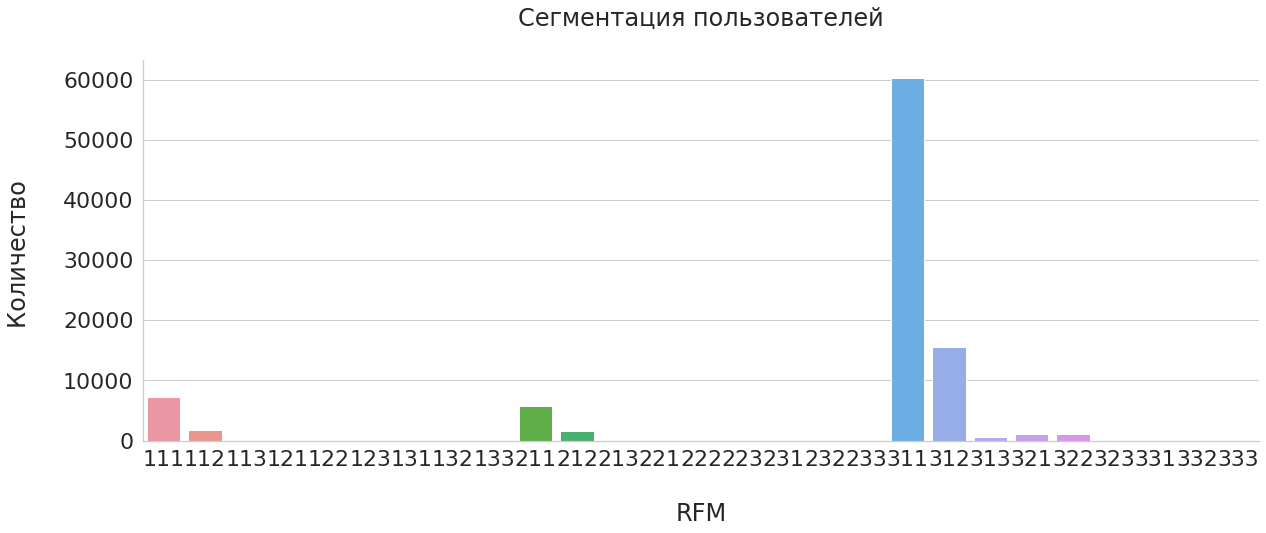

In [48]:
ax = sns.barplot(data=data, y='size', x='RFM')
ax.set_title('Сегментация пользователей\n')
ax.set_ylabel('Количество \n')
ax.set_xlabel('\nRFM') 
sns.despine()

из таблицы видно что коммерция пользуется спросом у тех аудитории, 
которые по большей части каждый пользователь делает покупки 1 раза в период свыше 130 дней, 
на сумму не более- 150 долл (доля которого почти 80%), а остальные 20% пользователей на суммы до 1000 долл. 

вторая часть аудитории состоит из тех, кто предпочитают возвращаться к покупкам в период от 90 дней до 130 дней, и при этом 
совершают покупки 1 раз в этот период, на сумму не превышающую 150 долл (80% пользователей), а сотальная часть 20%  предпочитают тратиться на сумму не более 1000 долл . 

третья часть группы клиентов, совершают покупки в интервале до 90 дней, а количество покупок составляет 
тоже 1 раз на сумму не более 150 долл, доля которых составляет 80%, а остальная доля 20% пользователей предпочитают расходовать сумму не более 1000 долл. 